In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

(evidence_approximation)=
# Evidence approximation

## Example (Quadratic)

Let's generate some synthetic data from a quadratic function:

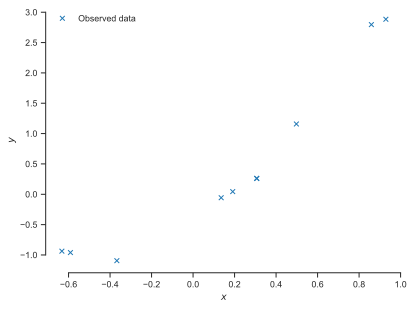

In [2]:
np.random.seed(12345)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = (
    w0_true
    + w1_true * x
    + w2_true * x ** 2
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's also copy paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [3]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

We are not going to implement the evidence approximation from scratch. Instead, we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge).
Scikit-learn makes some default assumptions about the hyper-priors of $\sigma^2$ and $\alpha$.
You can change these assumptions if you wish (they assign a Gamma distribution to the inverse of these parameters).
However, these hyper-priors are generated assuming the input-output pairs have been *normalized* before fitting.
To normalize the data, we subtract their empirical mean from the features and the outputs and divide by their L2 norm.
Then, you do regression between normalized features and outputs, and you make sure that you correctly transform the results of your analysis back to the original ones.
Scikit-learn makes all this easy, as you must pass a single argument that says you want to normalize.
Here is how you do it:

In [4]:
from sklearn.linear_model import BayesianRidge

# Parameters
degree = 3

# Design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)

# Fit
model = BayesianRidge(
    fit_intercept=False
).fit(Phi, y)

Here is how to get the noise variance $\sigma^2$ that scikit-learn finds:

In [5]:
# From scikit-learn: model.alpha_ is
# the "Estimated precision of the noise."
sigma = np.sqrt(1.0 / model.alpha_)
print(f'sigma = {sigma:1.2f}')

sigma = 0.11


Here is how to get the weight precision $\alpha$ that scikit-learn finds:

In [6]:
# It calls it lambda...
alpha = model.lambda_
print(f'alpha = {alpha:1.2f}')

alpha = 0.37


The posterior mean of the weights (for the normalized features) is accessible here:

In [7]:
m = model.coef_
print(f"Posterior mean w: {m}")

Posterior mean w: [-0.50892539  2.27047554  2.13898402 -0.56623545]


The posterior covariance matrix of the weights (for the normalized features) is here:

In [8]:
S = model.sigma_
print(f"Posterior covariance w:")
print(S)

Posterior covariance w:
[[ 0.00568448 -0.01045951 -0.01863946  0.02557349]
 [-0.01045951  0.0464708   0.0454668  -0.09539202]
 [-0.01863946  0.0454668   0.08190154 -0.11769764]
 [ 0.02557349 -0.09539202 -0.11769764  0.22394891]]


Let's now make predictions separating aleatory and epistemic uncertainty just like we did before:

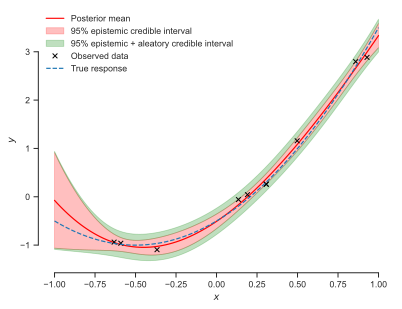

In [11]:
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

# Predict with model
yy_mean, yy_measured_std = model.predict(
    Phi_xx,
    return_std=True
)

# Extract epistemic predictive standard deviation
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
# Epistemic 95% credible interval
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory 95% credible interval
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# The true response
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

# Plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
ax.plot(x, y, 'kx', label='Observed data')
ax.plot(xx, yy_true, "--", label="True response")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

It's a good idea to organize these into functions that we will be using later:

In [12]:
def plot_posterior_predictive(
    model,
    xx,
    phi_func,
    phi_func_args=(),
    y_true=None
):
    """Plot the posterior predictive separating
    aleatory and espitemic uncertainty.
    
    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.
    
    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    y_true        -- The true response for plotting.
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    yy_mean, yy_measured_std = model.predict(
        Phi_xx,
        return_std=True
    )
    sigma = np.sqrt(1.0 / model.alpha_)
    yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std

    fig, ax = plt.subplots()
    ax.plot(xx, yy_mean, 'r', label="Posterior mean")
    ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.25,
        label="95% epistemic credible interval"
    )
    ax.fill_between(
        xx,
        yy_lae,
        yy_le,
        color='green',
        alpha=0.25
    )
    ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.25,
        label="95% epistemic + aleatory credible interval"
    )
    ax.plot(x, y, 'kx', label='Observed data')
    if y_true is not None:
        ax.plot(xx, y_true, "--", label="True response")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True);

Here is how you can use it:

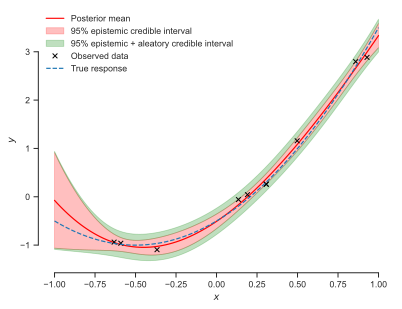

In [13]:
plot_posterior_predictive(
    model,
    xx,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
    y_true=yy_true
)

What if you wanted to get the samples from the posterior?

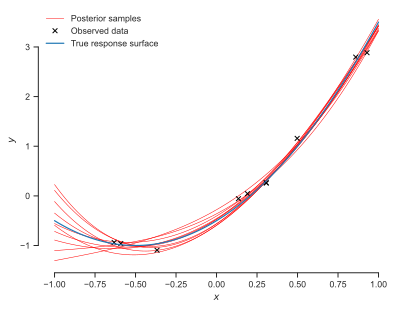

In [14]:
import scipy.stats as st

xx = np.linspace(-1, 1, 100)

# The true response for plotting
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

w_post = st.multivariate_normal(mean=m, cov=S)
# If you get an error because the covariance matrix is singular, add something small
# to the diagonal. The covariance matrix is always positive definite (and non-singular)
# but it may have eigenvalues so close to zero that the numerical algorithms find
# them to be slightly negative. This is an artifact of the floating point precision.
# Comment the line above and uncomment the line below to fix the problem.
# w_post = st.multivariate_normal(mean=m, cov=S + 1e-6 * np.eye(S_norm.shape[0]))

# Plot
fig, ax = plt.subplots()
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = Phi_xx @ w_sample
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.plot([], [], "r", lw=0.5, label="Posterior samples")
ax.plot(x, y, 'kx', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

It is useful to arrange this into a function as well:

In [15]:
def plot_posterior_samples(
    model,
    xx,
    phi_func,
    phi_func_args=(),
    num_samples=10,
    y_true=None,
    nugget=1e-6 
):
    """Plot posterior samples from the model.
    
    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.
    
    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    num_samples   -- The number of samples to take.
    y_true        -- The true response for plotting.
    nugget        -- A small number to add the covariance
                     if it is not positive definite
                     (numerically).
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    m = model.coef_
    S = model.sigma_
    w_post = st.multivariate_normal(
        mean=m,
        cov=S + nugget * np.eye(S.shape[0])
    )
    fig, ax = plt.subplots()
    for _ in range(num_samples):
        w_sample = w_post.rvs()
        yy_sample = Phi_xx @ w_sample
        ax.plot(xx, yy_sample, 'r', lw=0.5)
    ax.plot([], [], "r", lw=0.5, label="Posterior samples")
    ax.plot(x, y, 'kx', label='Observed data')
    ax.plot(xx, yy_true, label='True response surface')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True);

And here is how this can be used:

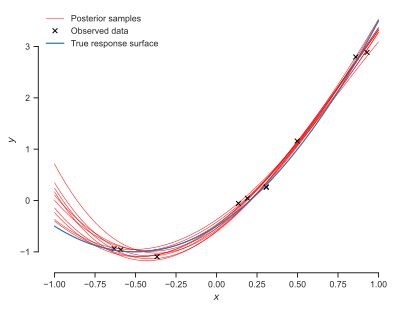

In [16]:
plot_posterior_samples(
    model,
    xx,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
    y_true=yy_true
)

### Questions
+ Rerun with a smaller number of observations, say $n=5$. What happens to the epistemic uncertainty?
+ Rerun with a minimal number of observations, say $n=2$. What happens then? (The step that samples from the posterior may not work as expected. Please look at the comment in the code to fix the problem.)
+ Rerun everything with a higher degree polynomial. Try $4$, $8$, and $16$.
Notice that the fit remains good in between, but how you extrapolate changes. Why?